# Data Analysis

## Prepare data

### Importing Libraries and Data

In [94]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os
import json
import scipy.stats
from sklearn.metrics import mutual_info_score

In [95]:
# read the csv file into a pandas dataframe
summary_df = pd.read_csv('../data/summary_df.csv', index_col=0)

# check the first 5 rows of the dataframe
summary_df.head()

,random,combinatory,std,complexity-std,loss-std,true-confusion,formula
Equation,,,,,,,
II.11.17,[ 7. 21. 15. 17. 21. 43. 41. 25. 14. 25. 11. 2...,[30. 35. 50. 28. 26. 25. 37. 31. 27. 38. 48. 3...,[22. 13. 17. 12. 13. 16. 12. 11. 14. 13. 17. 2...,[10. 18. 19. 11. 17. 19. 10. 19. 18. 6. 18. 1...,[16. 16. 20. 16. 14. 14. 14. 16. 16. 19. 7. 1...,[10. 10. 10. 8. 10. 11. 8. 9. 12. 7. 12. 1...,n_0*(1+p_d*Ef*cos(theta)/(kb*T))
I.24.6,[ nan 26. 115. nan nan 78. nan nan nan ...,[169. 29. 49. 93. 158. 227. 292. 43. 56. ...,[254. 84. 178. 166. 73. 197. 19. 135. 180. ...,[ 27. 136. 94. 102. 104. 127. 98. 18. 11. ...,[ 95. 92. 95. 95. 93. 99. 95. 163. 55. ...,[ 69. 71. 80. 63. 24. 47. 60. 110. nan ...,1/2*m*(omega**2+omega_0**2)*1/2*x**2
II.11.20,[27. 15. 34. 26. 20. 13. 18. 23. 15. 25. 25. 1...,[16. 16. 15. 15. 9. 18. 21. 13. 21. 13. 15. 1...,[17. 9. 18. 18. 12. 17. 14. 13. 7. 13. 12. 1...,[ 8. 8. 13. 93. 108. 105. 113. 150. 90. ...,[11. 15. 14. 12. 17. 15. 17. 15. 15. 13. 15. 1...,[14. 11. 10. 9. 10. 10. 13. 14. 9. 14. 10. 1...,n_rho*p_d**2*Ef/(3*kb*T)
III.13.18,[15. 30. 8. 7. 29. 10. 10. 11. 11. 13. nan 1...,[ 5. 9. 16. 16. 7. 13. 10. 16. 12. 16. 11. ...,[ 6. 13. 16. 10. 11. 10. 9. 8. 8. 10. 13. 1...,[ 5. 9. 7. 11. 15. 8. 17. 9. 13. 19. 10. 1...,[17. 16. 9. 13. 22. 10. 15. 9. 7. 12. 9. 1...,[ 8. 8. 9. 8. 10. 10. 8. 7. 8. 11. 11. 1...,2*E_n*d**2*k/(h/(2*pi))
I.13.4,[ 39. 17. 59. 205. 32. 51. 112. 265. 280. ...,[ 50. 9. 16. 21. 12. 25. 44. 48. 41. ...,[21. 45. 27. 54. 18. 24. 34. 39. 74. 27. 49. 3...,[ 18. 58. 18. 42. 32. 14. 144. 28. 43. ...,[ 97. 23. 23. 96. 94. 90. 87. 34. 78. ...,[26. 27. 15. 24. 32. 10. 28. 17. 30. 21. 38. 2...,1/2*m*(v**2+u**2+w**2)


Import/Create the trial summary

In [96]:
def trial_summary(save_to_file=True):
    """Creates a dictionary with the number of finished jobs and average last_n for each equation and algorithm"""
    # read the finished jobs file
    with open('../data/finished_jobs.json') as f:
        finished_jobs = json.load(f)
    # create a dictionary with the number of finished jobs and average last_n for each equation and algorithm
    trial_summary = {}
    for job in finished_jobs:
        # job[0] is the job name, job[1] is the parameters
        equation = job[0][0].split(" ")[1]
        algorithm = job[0][1] if job[0][1] != "true-confusion" else "true-mod" # change the name of "true-confusion" to "true-mod"
        trial = job[0][2]
        last_n = job[1]["last_n"]
        try:
            converged = job[1]["converged"]
        except KeyError:
            if last_n <=499:
                converged = False
            else:
                converged = True
        # if the equation is not in the dictionary, add it
        if equation not in trial_summary:
            trial_summary[equation] = {}
        # if the algorithm is not in the dictionary, add it
        if algorithm not in trial_summary[equation]:
            trial_summary[equation][algorithm] = {}
        # add the last_n to the dictionary for the equation and algorithm if the job converged
        trial_summary[equation][algorithm][trial] = last_n if converged else None
    if save_to_file:
        with open('../data/trial_data.json', "w") as f:
            json.dump(trial_summary, f)
    return trial_summary

In [97]:
trial_summary_dict = trial_summary()

### Data Transformation & Cleaning

Rename the column "true-confusion" to "true-mod" to be consistent with the other dataframes.

In [98]:
# rename the column "true-confusion" to "true-mod"
summary_df.rename(columns={'true-confusion': 'true-mod'}, inplace=True)

Re-transform the dataframes to have the same format as the original dataframes.

In [99]:
def str_to_list(string):
    """Convert a string to a list of floats. Replace 'nan' with np.nan. Return a numpy array."""
    string = str(string).replace('[', '').replace(']', '').replace('\n',' ').split(' ')
    string = [x for x in string if x != '']
    string = [float(i) for i in string]
    # replace nan with np.nan
    string = [np.nan if x == 'nan' else x for x in string]
    # convert to numpy array
    string = np.array(string)
    return string

In [100]:
# convert all columns to list
for col in summary_df.columns[:-1]:
    summary_df[col] = summary_df[col].apply(str_to_list)

Filtering out the data to only include the columns we need for our analysis. The threshold of minimum number of samples is set as `treshold_value`.

In [101]:
threshold_value = 50 # set the minimum number of samples for the approach at a equation

# make a new dataframe with the length of each list
summary_df_len = summary_df.copy()
for col in summary_df_len.columns[:-1]:
    summary_df_len[col] = summary_df_len[col].apply(len)

# Define the columns to check
columns_to_check = ['random', 'combinatory','std','complexity-std','loss-std','true-mod']	

# Filter and print rows where at least one element in the specified columns is less than the threshold
filtered_rows = summary_df_len[(summary_df_len[columns_to_check] < threshold_value).any(axis=1)]
print(filtered_rows)

          random  combinatory  std  complexity-std  loss-std  true-mod  \
Equation                                                                 
I.24.6        42           98  100              44        12        90   
II.35.18      94          100   99              84        48        97   
II.21.32      93           17   36              19        25         1   
I.50.26        1            1    1               1        59        63   

                                             formula  
Equation                                              
I.24.6          1/2*m*(omega**2+omega_0**2)*1/2*x**2  
II.35.18  n_0/(exp(mom*B/(kb*T))+exp(-mom*B/(kb*T)))  
II.21.32                  q/(4*pi*epsilon*r*(1-v/c))  
I.50.26      x1*(cos(omega*t)+alpha*cos(omega*t)**2)  


In [102]:
# create a new dataframe without the filtered rows
summary_df_filtered = summary_df[~summary_df.index.isin(filtered_rows.index)]
# print the shape of the original and filtered dataframe
print(f"Original dataframe shape: {summary_df.shape}")
print(f"Filtered dataframe shape: {summary_df_filtered.shape}")

Original dataframe shape: (42, 7)
Filtered dataframe shape: (38, 7)


## Plot Data

### Correlation Plots

In [103]:
def same_keys(dict1, dict2):
    """Return the items for that the keys are in both dictionaries"""
    return {k: (dict1[k], dict2[k]) for k in dict1.keys() if k in dict2.keys()}

def get_same_trials_dict(trial_summary_dict, approach_1, approach_2):
    # create dataframe for approach 1 and approach 2
    approach_1_df = pd.DataFrame()
    approach_2_df = pd.DataFrame()
    for equation in trial_summary_dict.keys():
        try:
            df1 = pd.DataFrame(trial_summary_dict[equation][approach_1], index=[equation])
            df2 = pd.DataFrame(trial_summary_dict[equation][approach_2], index=[equation])
            approach_1_df = pd.concat([approach_1_df, df1], sort=False)
            approach_2_df = pd.concat([approach_2_df, df2], sort=False)
        except KeyError:
            continue
    # for every equation, get the trials that are in both dataframes
    same_trials = {}
    for equation in trial_summary_dict:
        try:
            same_trials[equation] = same_keys(trial_summary_dict[equation][approach_1], trial_summary_dict[equation][approach_2])
        except KeyError:
            continue
    return same_trials

def flatten_same_trials_dict(same_trials_dict, equation=None):
    """Flatten the dictionary to be two lists for the two approaches"""
    approach_1_list = []
    approach_2_list = []
    for equation in same_trials_dict:
        if equation is not None and equation != equation:
            continue
        for trial in same_trials_dict[equation]:
            approach_1_list.append(same_trials_dict[equation][trial][0])
            approach_2_list.append(same_trials_dict[equation][trial][1])
    return approach_1_list, approach_2_list

def prepare_trial_data(trial_summary_dict, approach_1, approach_2, equation=None, nan_value = 650, consider_nan=True):
    # get the trials
    same_trials_dict = get_same_trials_dict(trial_summary_dict, approach_1, approach_2)
    # flatten the dictionary to be two lists for the two approaches
    approach_list_1, approach_list_2 = flatten_same_trials_dict(same_trials_dict, equation)
    if consider_nan:
        # replace all None values with nan_value
        approach_list_1 = [nan_value if x is None else x for x in approach_list_1]
        approach_list_2 = [nan_value if x is None else x for x in approach_list_2]
    else:
        # find all indexes where the value is None for each list
        none_indexes_1 = [i for i, x in enumerate(approach_list_1) if x is None]
        none_indexes_2 = [i for i, x in enumerate(approach_list_2) if x is None]
        # concat the two lists and remove the indexes where the value is None in both lists
        none_indexes = none_indexes_1 + none_indexes_2
        approach_list_1 = [i for j, i in enumerate(approach_list_1) if j not in none_indexes]
        approach_list_2 = [i for j, i in enumerate(approach_list_2) if j not in none_indexes]
    return approach_list_1, approach_list_2

def correlation_plot_of_approaches(trial_summary_dict, approach_1, approach_2, equation=None, nan_value = 650, consider_nan=True, figsize=(5,5), lim=None, figure=True, vmin=0, vmax=4000, cmap=plt.cm.Reds):
    # get the trials
    approach_list_1, approach_list_2 = prepare_trial_data(trial_summary_dict, approach_1, approach_2, equation, nan_value, consider_nan)
    # Calculate Pearson Correlation Coefficient
    pearson_coefficient, _ = scipy.stats.pearsonr(approach_list_1, approach_list_2)
    # Calculate Spearman's Rank Correlation Coefficient
    spearman_coefficient, _ = scipy.stats.spearmanr(approach_list_1, approach_list_2)
    # Calculate Mutual Information Coefficient (MCI)
    mci = mutual_info_score(approach_list_1, approach_list_2)
    # declare the correlation dictionary
    correlation=dict(pearson_coefficient=pearson_coefficient, spearman_coefficient=spearman_coefficient, mci=mci)

    # plot the two lists as x and y
    if figure:
        plt.figure(figsize=figsize)
    
    #plt.scatter(approach_list_2, approach_list_1, s=2, color='black', alpha=0.2)
    # make a hist2d plot
    hist=plt.hist2d(approach_list_2, approach_list_1, bins=(20,20), cmap=cmap, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax))
    # plot the correlation and add the number of samples
    text_top = f"P.:{correlation['pearson_coefficient']:.2f}  S.:{correlation['spearman_coefficient']:.2f}  MCI:{correlation['mci']:.2f}  #:{len(approach_list_1)}"
    plt.text(0.5, 0.98, text_top, transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='center', fontsize=10)
    text_right=f"x:{approach_1}  y:{approach_2}"
    plt.text(0.98, 0.5, text_right, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='right', fontsize=10, rotation=90)
    if consider_nan:
        plt.xlim([0, nan_value+100] if not lim else lim)
        plt.ylim([0, nan_value+100] if not lim else lim)
    else:
        plt.xlim([0, 500] if not lim else lim)
        plt.ylim([0, 500] if not lim else lim)
    if figure:
        plt.xlabel(f"Steps for {approach_2}")
        plt.ylabel(f"Steps for {approach_1}")
        plt.title(f"{approach_1} vs {approach_2}")
    #plt.tight_layout()
    #plt.show()
    return correlation, hist

def correlation_plot_comparison(trial_summary_dict, equation=None, nan_value=650, consider_nan=True, figsize=(5,5), lim=None, filename=None, vmin=1, vmax=4000, cmap=plt.cm.PuBuGn):
    # create a 6x6 grid of subplots
    fig, axs = plt.subplots(6, 6, figsize=(20,20), sharex=True, sharey=True)
    approaches = ['random', 'combinatory','std','complexity-std','loss-std','true-mod']
    # iterate over all combinations of approaches
    for i in range(len(approaches)):
        for j in range(len(approaches)):
            # # skip the diagonal
            # if i == j:
            #     continue
            # plot the correlation
            plt.sca(axs[i, j])
            correlation, hist = correlation_plot_of_approaches(trial_summary_dict, approaches[i], approaches[j] , equation, nan_value, consider_nan, figsize, lim, figure=False, vmin=vmin, vmax=vmax, cmap=cmap)
            # add the plot to the grid
            plt.sca(axs[i, j])
            # color the facecolor of the plot based on the correlation using a colormap

            # Create a custom colormap for the correlation value
            alpha = 0.5
            colormap = plt.cm.RdYlGn  # Use your desired colormap
            colors = colormap(np.arange(colormap.N))
            colors[:, -1] = alpha  # Set alpha value for all colors in the colormap
            custom_colormap = mcolors.ListedColormap(colors)
            #plt.gca().set_facecolor(custom_colormap(correlation))
    # Create a colorbar on the right side of the grid
    cbar_ax = fig.add_axes([0.91, 0.02, 0.01, 0.9])  # Adjust these values as needed
    # Specify the mappable explicitly for the colorbar
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax))
    mappable.set_array([])  # Set an empty array or data here
    cbar = plt.colorbar(mappable, cax=cbar_ax)
    cbar.set_label('Number of trials', fontsize=15, weight='bold')
    # set y-ticks of cbar
    cbar.ax.tick_params(labelsize=14)
    # add labels for the rows and columns
    rows = approaches
    cols = approaches
    for ax, col in zip(axs[0], cols):
        ax.set_title(col, weight='bold', fontsize=15)
    for ax, row in zip(axs[:,0], rows):
        ax.set_ylabel(row, rotation=90, weight='bold', fontsize=15)
    plt.tight_layout()
    # title for the whole grid and add padding so the titles don't overlap with the subplots
    plt.suptitle(f"Correlation plots for all approaches for {equation if equation else 'all equations'}", fontsize=20, weight='bold')
    # text under suptitle
    plt.figtext(0.5, 0.96, f"Consider 'not found' trials: {'True' if consider_nan else 'False'}    'not found'_value: {nan_value if consider_nan else '-'}    limits: {lim}", ha='center', va='top', fontsize=15)
    # add legend for correlations abreviatiosn
    plt.figtext(0.95, 0.98, "P. : Pearson Correlation Coefficient\nS. : Spearman's Rank Correlation Coefficient\nMCI : Mutual Information Coefficient\n# : Number of Trials", ha='right', va='top', fontsize=12)
    plt.subplots_adjust(top=0.92, right=0.9)
    filename = filename if filename else f"correlation_plots_grid_{equation.replace('.','-') if equation else 'all_equations'}_{'consider_nan' if consider_nan else 'not_consider_nan'}_{nan_value}_lim_{lim}.pdf"
    plt.savefig(f'../figures/{filename}')
    plt.show()
    

Create a correlation plot for all approaches and all trials of all equations.

/var/folders/z1/qmxvz11d13jc31fr03kvl6gw0000gn/T/ipykernel_36103/3615251552.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


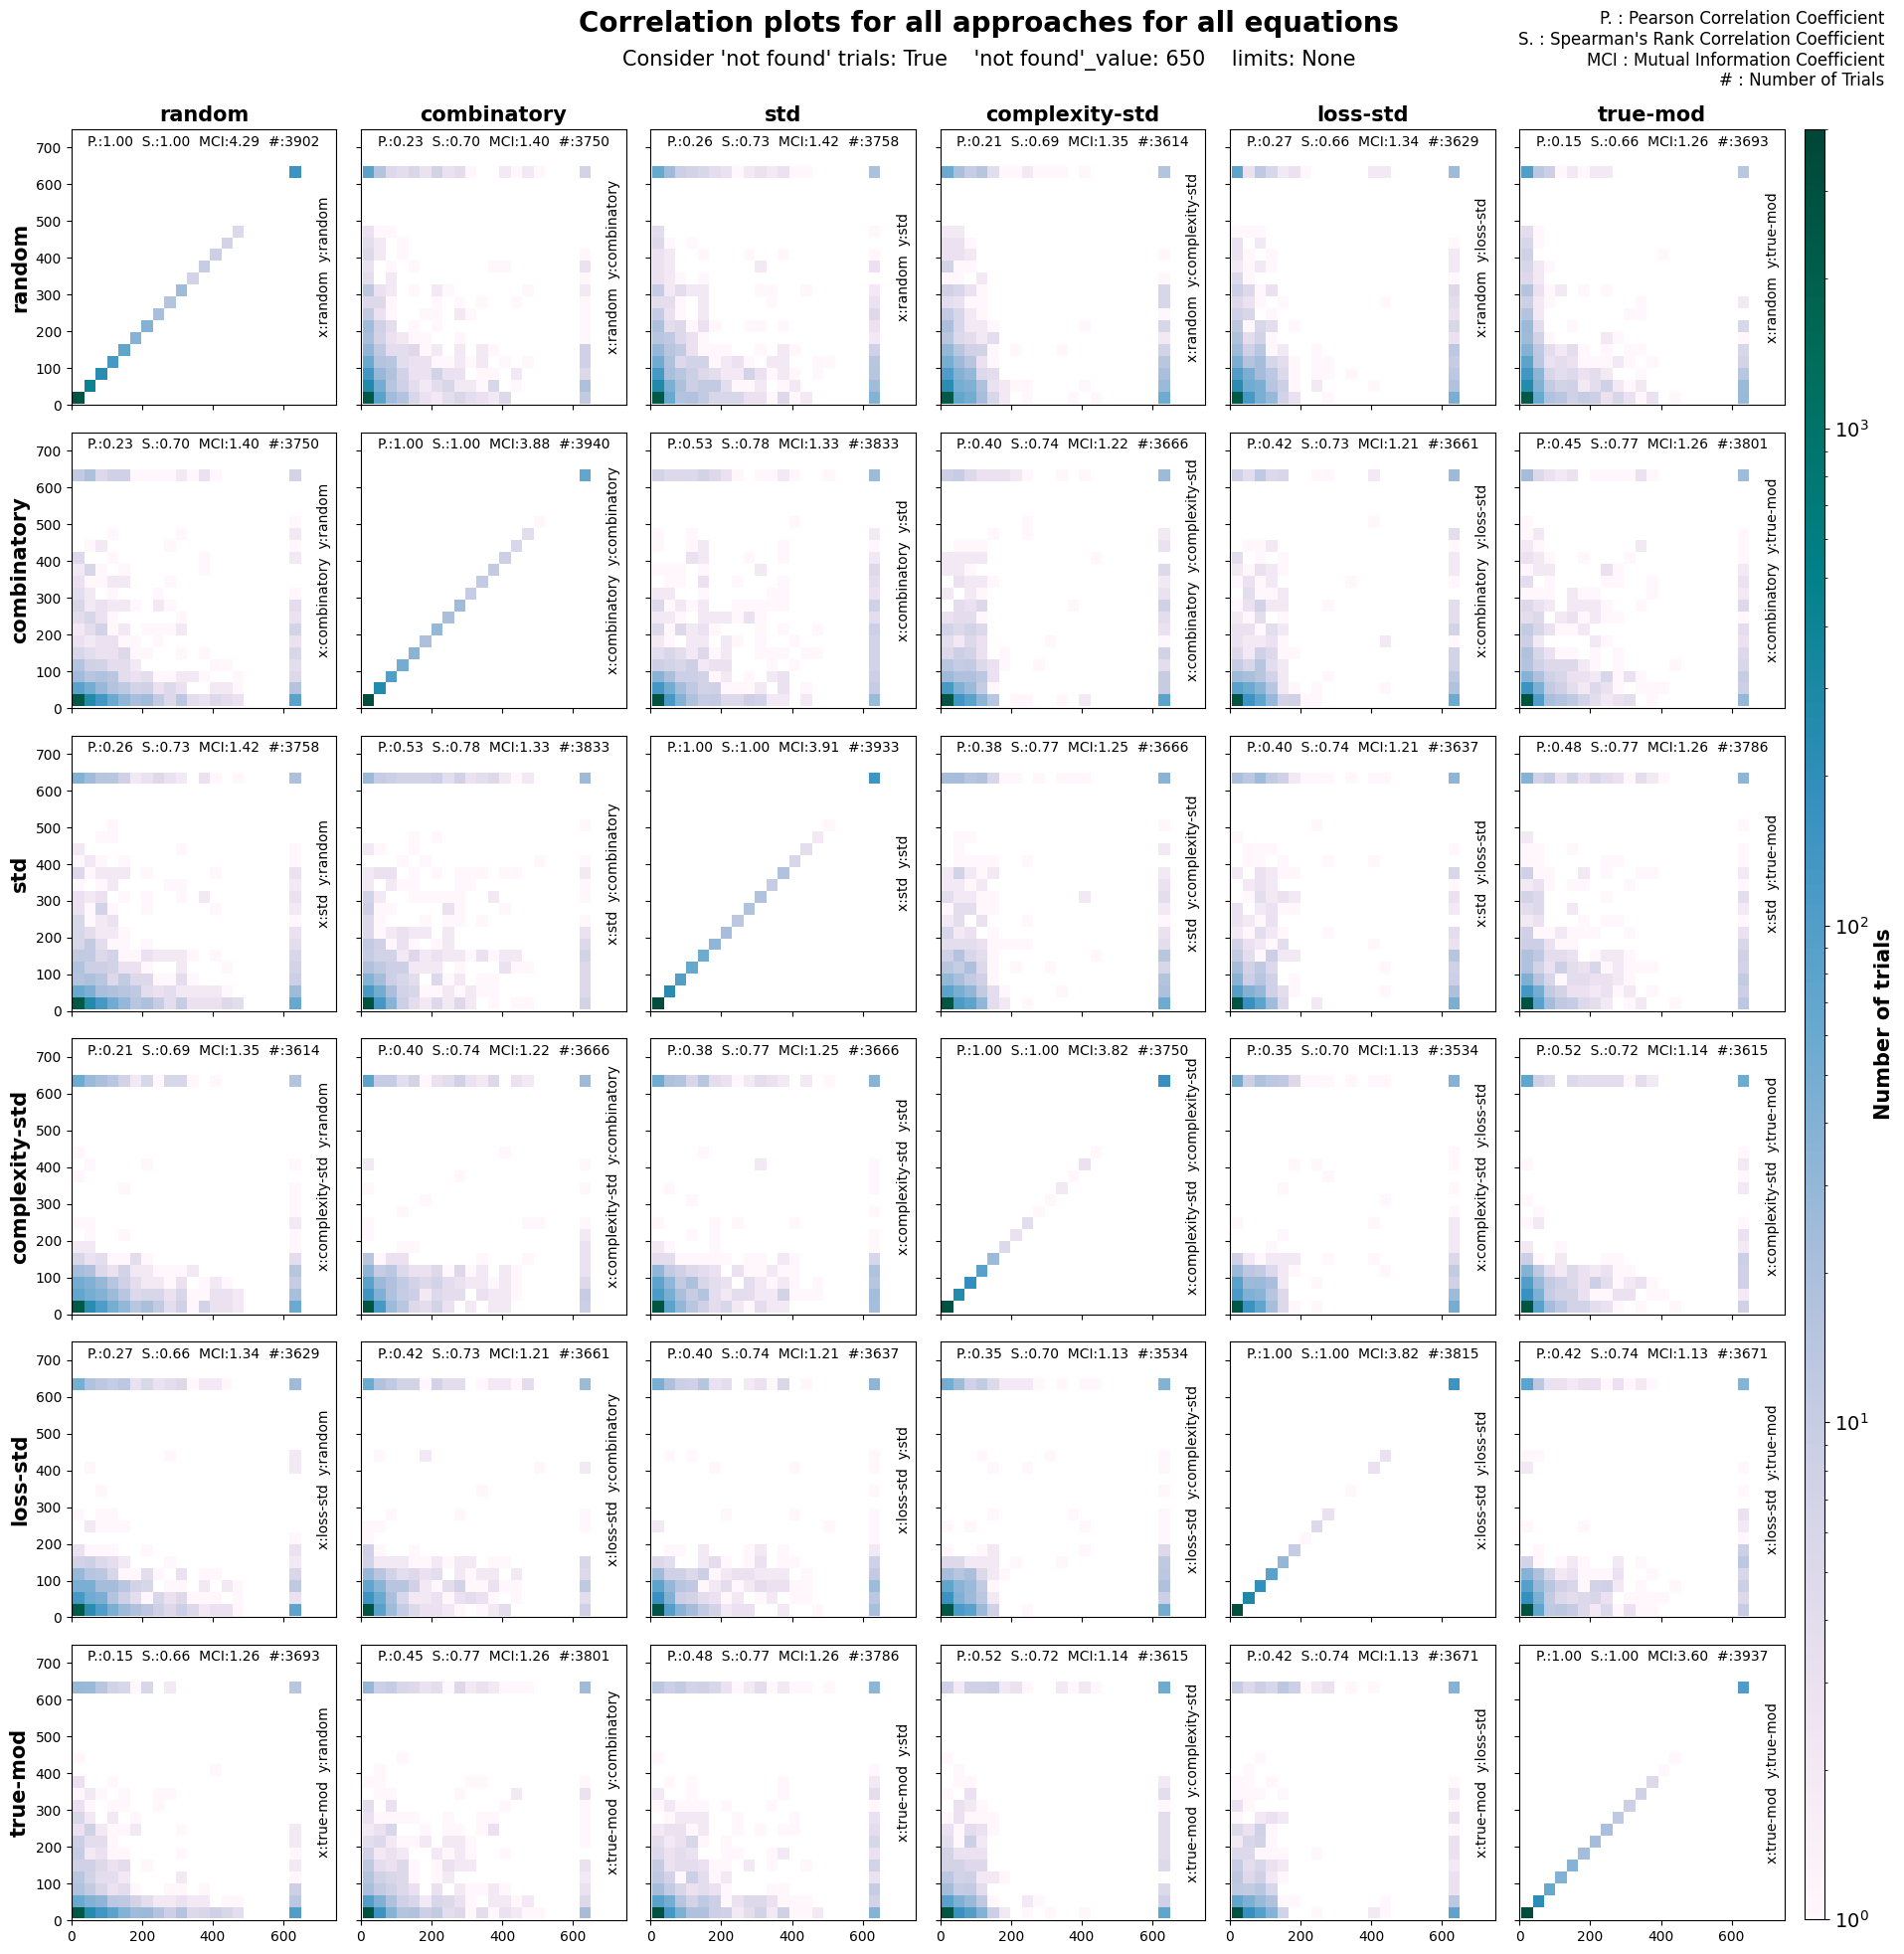

In [104]:
correlation_plot_comparison(trial_summary_dict)

Comparison of the correlation plots for all approaches and all trials of all equations but ignoring the "not found" trials.

/var/folders/z1/qmxvz11d13jc31fr03kvl6gw0000gn/T/ipykernel_36103/3615251552.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


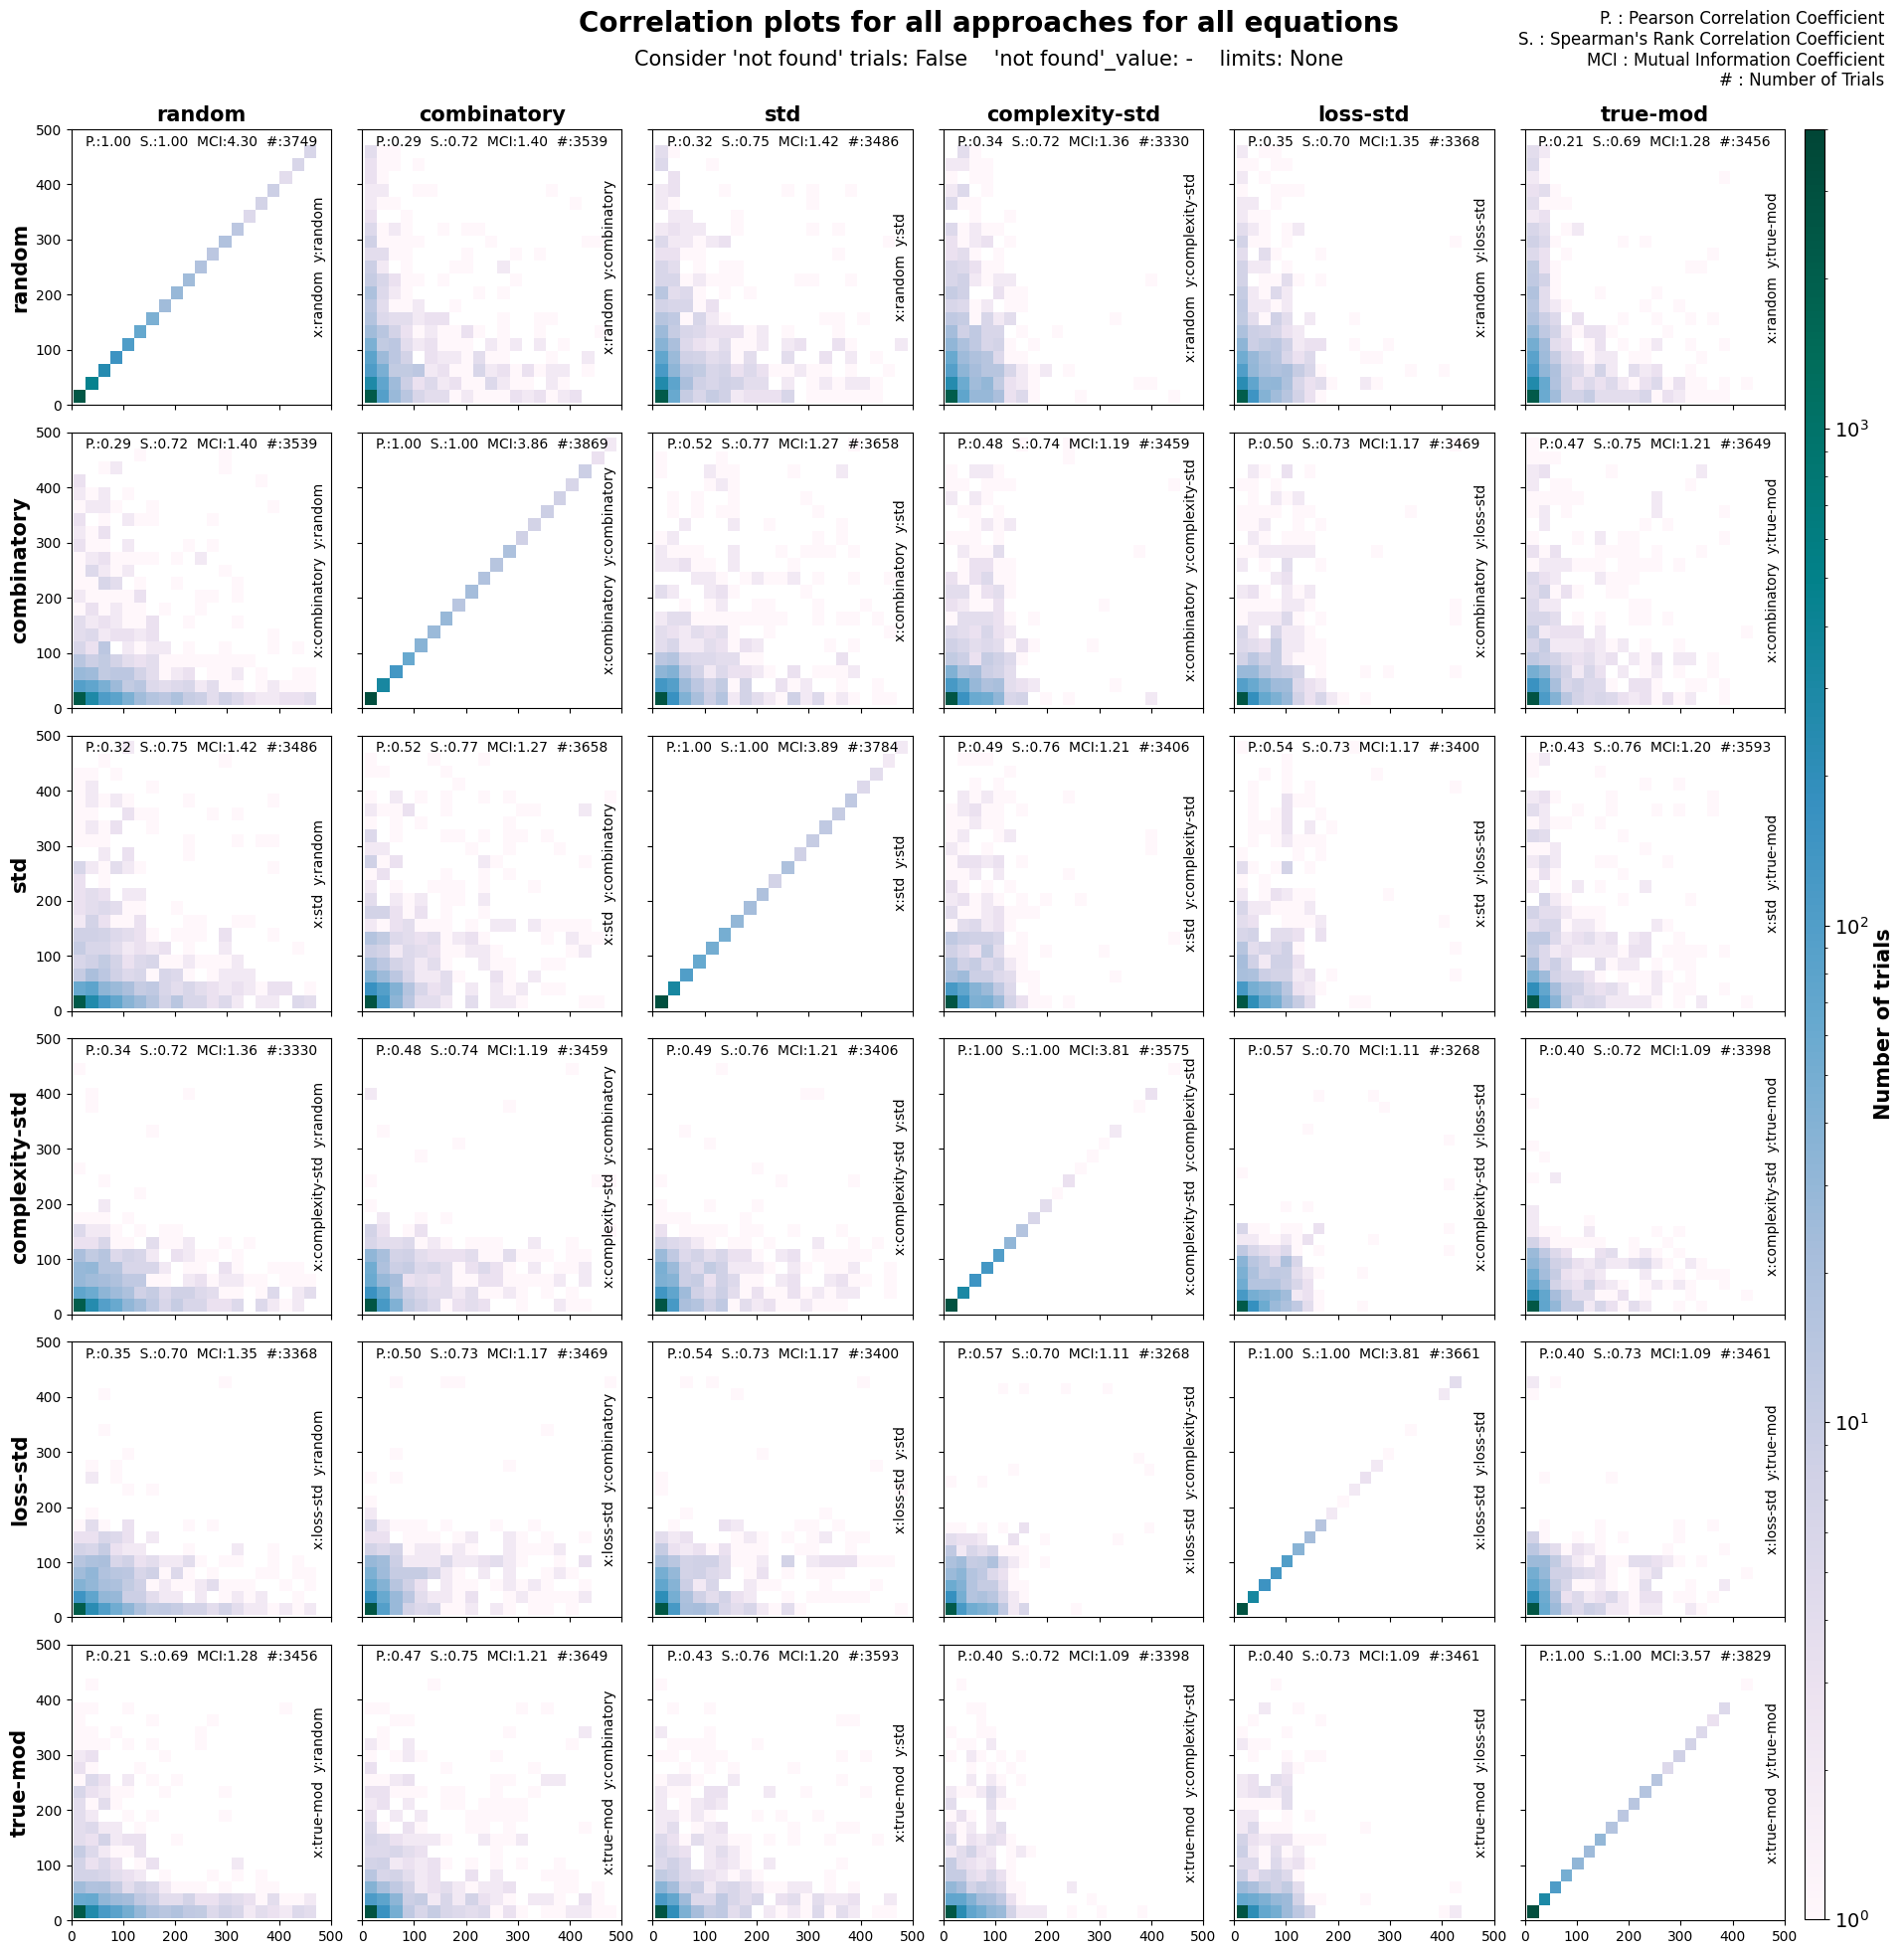

In [105]:
correlation_plot_comparison(trial_summary_dict, consider_nan=False)

smaller limits

/var/folders/z1/qmxvz11d13jc31fr03kvl6gw0000gn/T/ipykernel_36103/3615251552.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


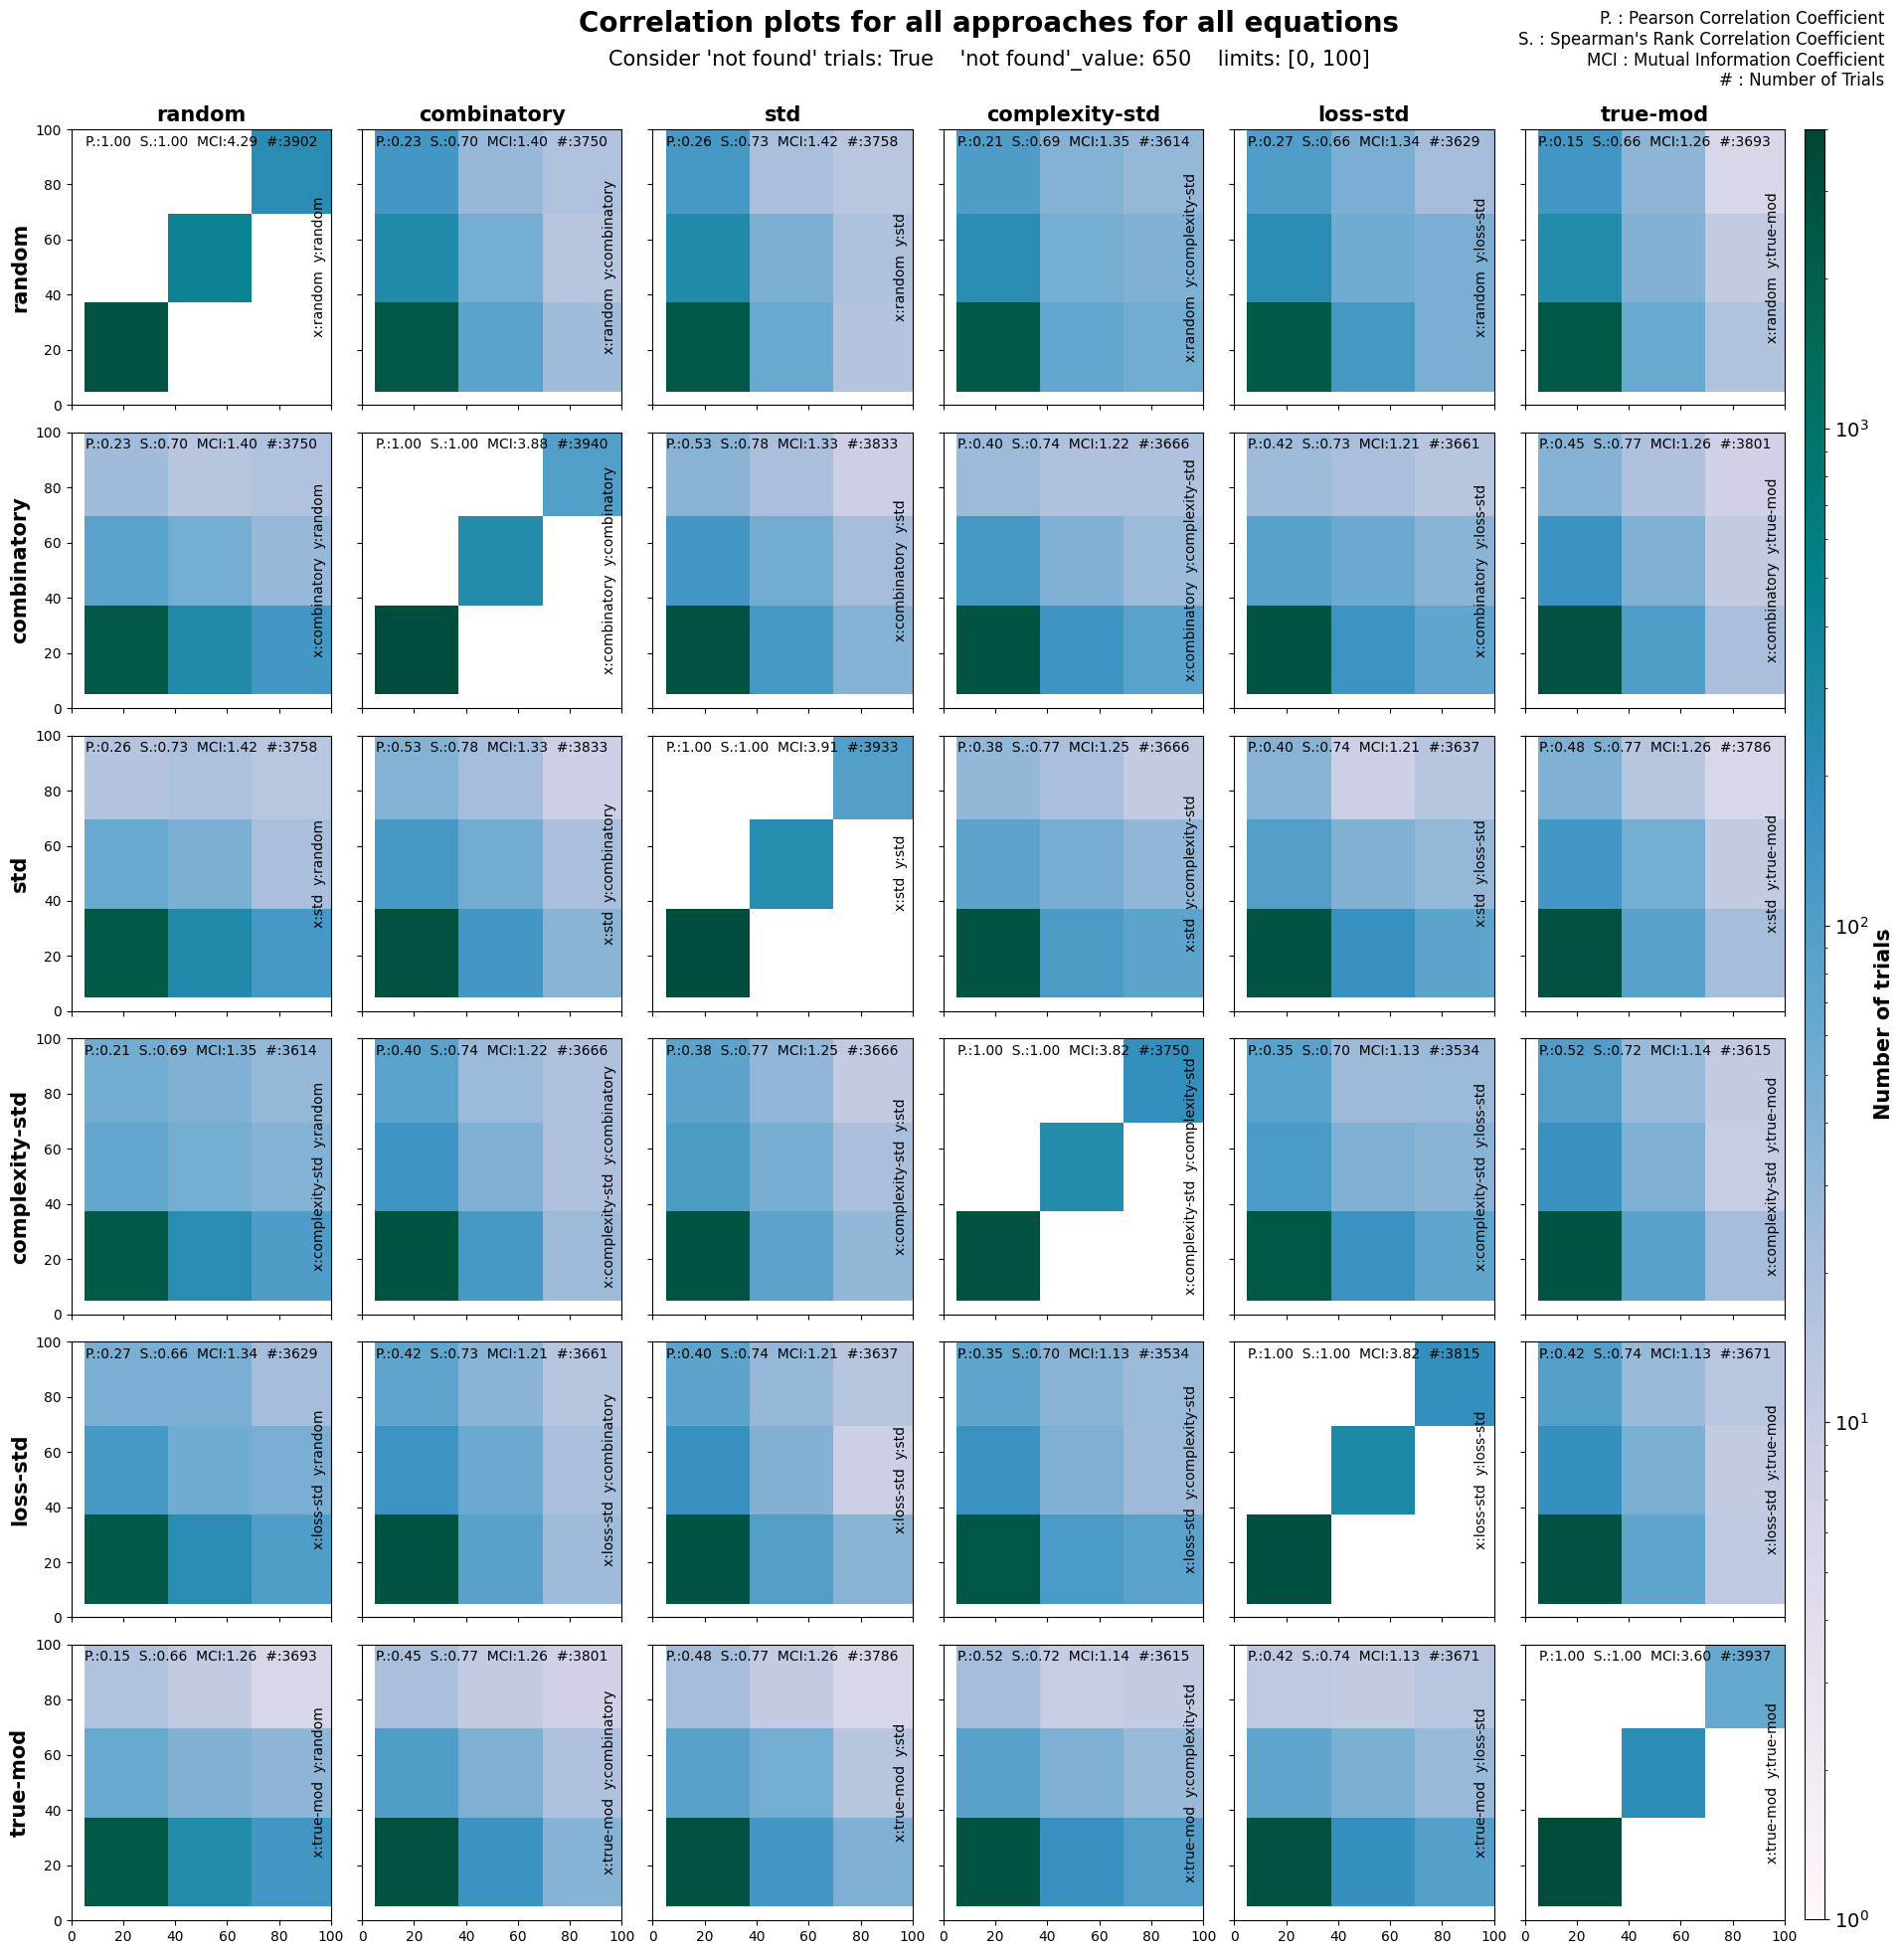

In [106]:
correlation_plot_comparison(trial_summary_dict, lim=[0, 100])

/var/folders/z1/qmxvz11d13jc31fr03kvl6gw0000gn/T/ipykernel_36103/3615251552.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


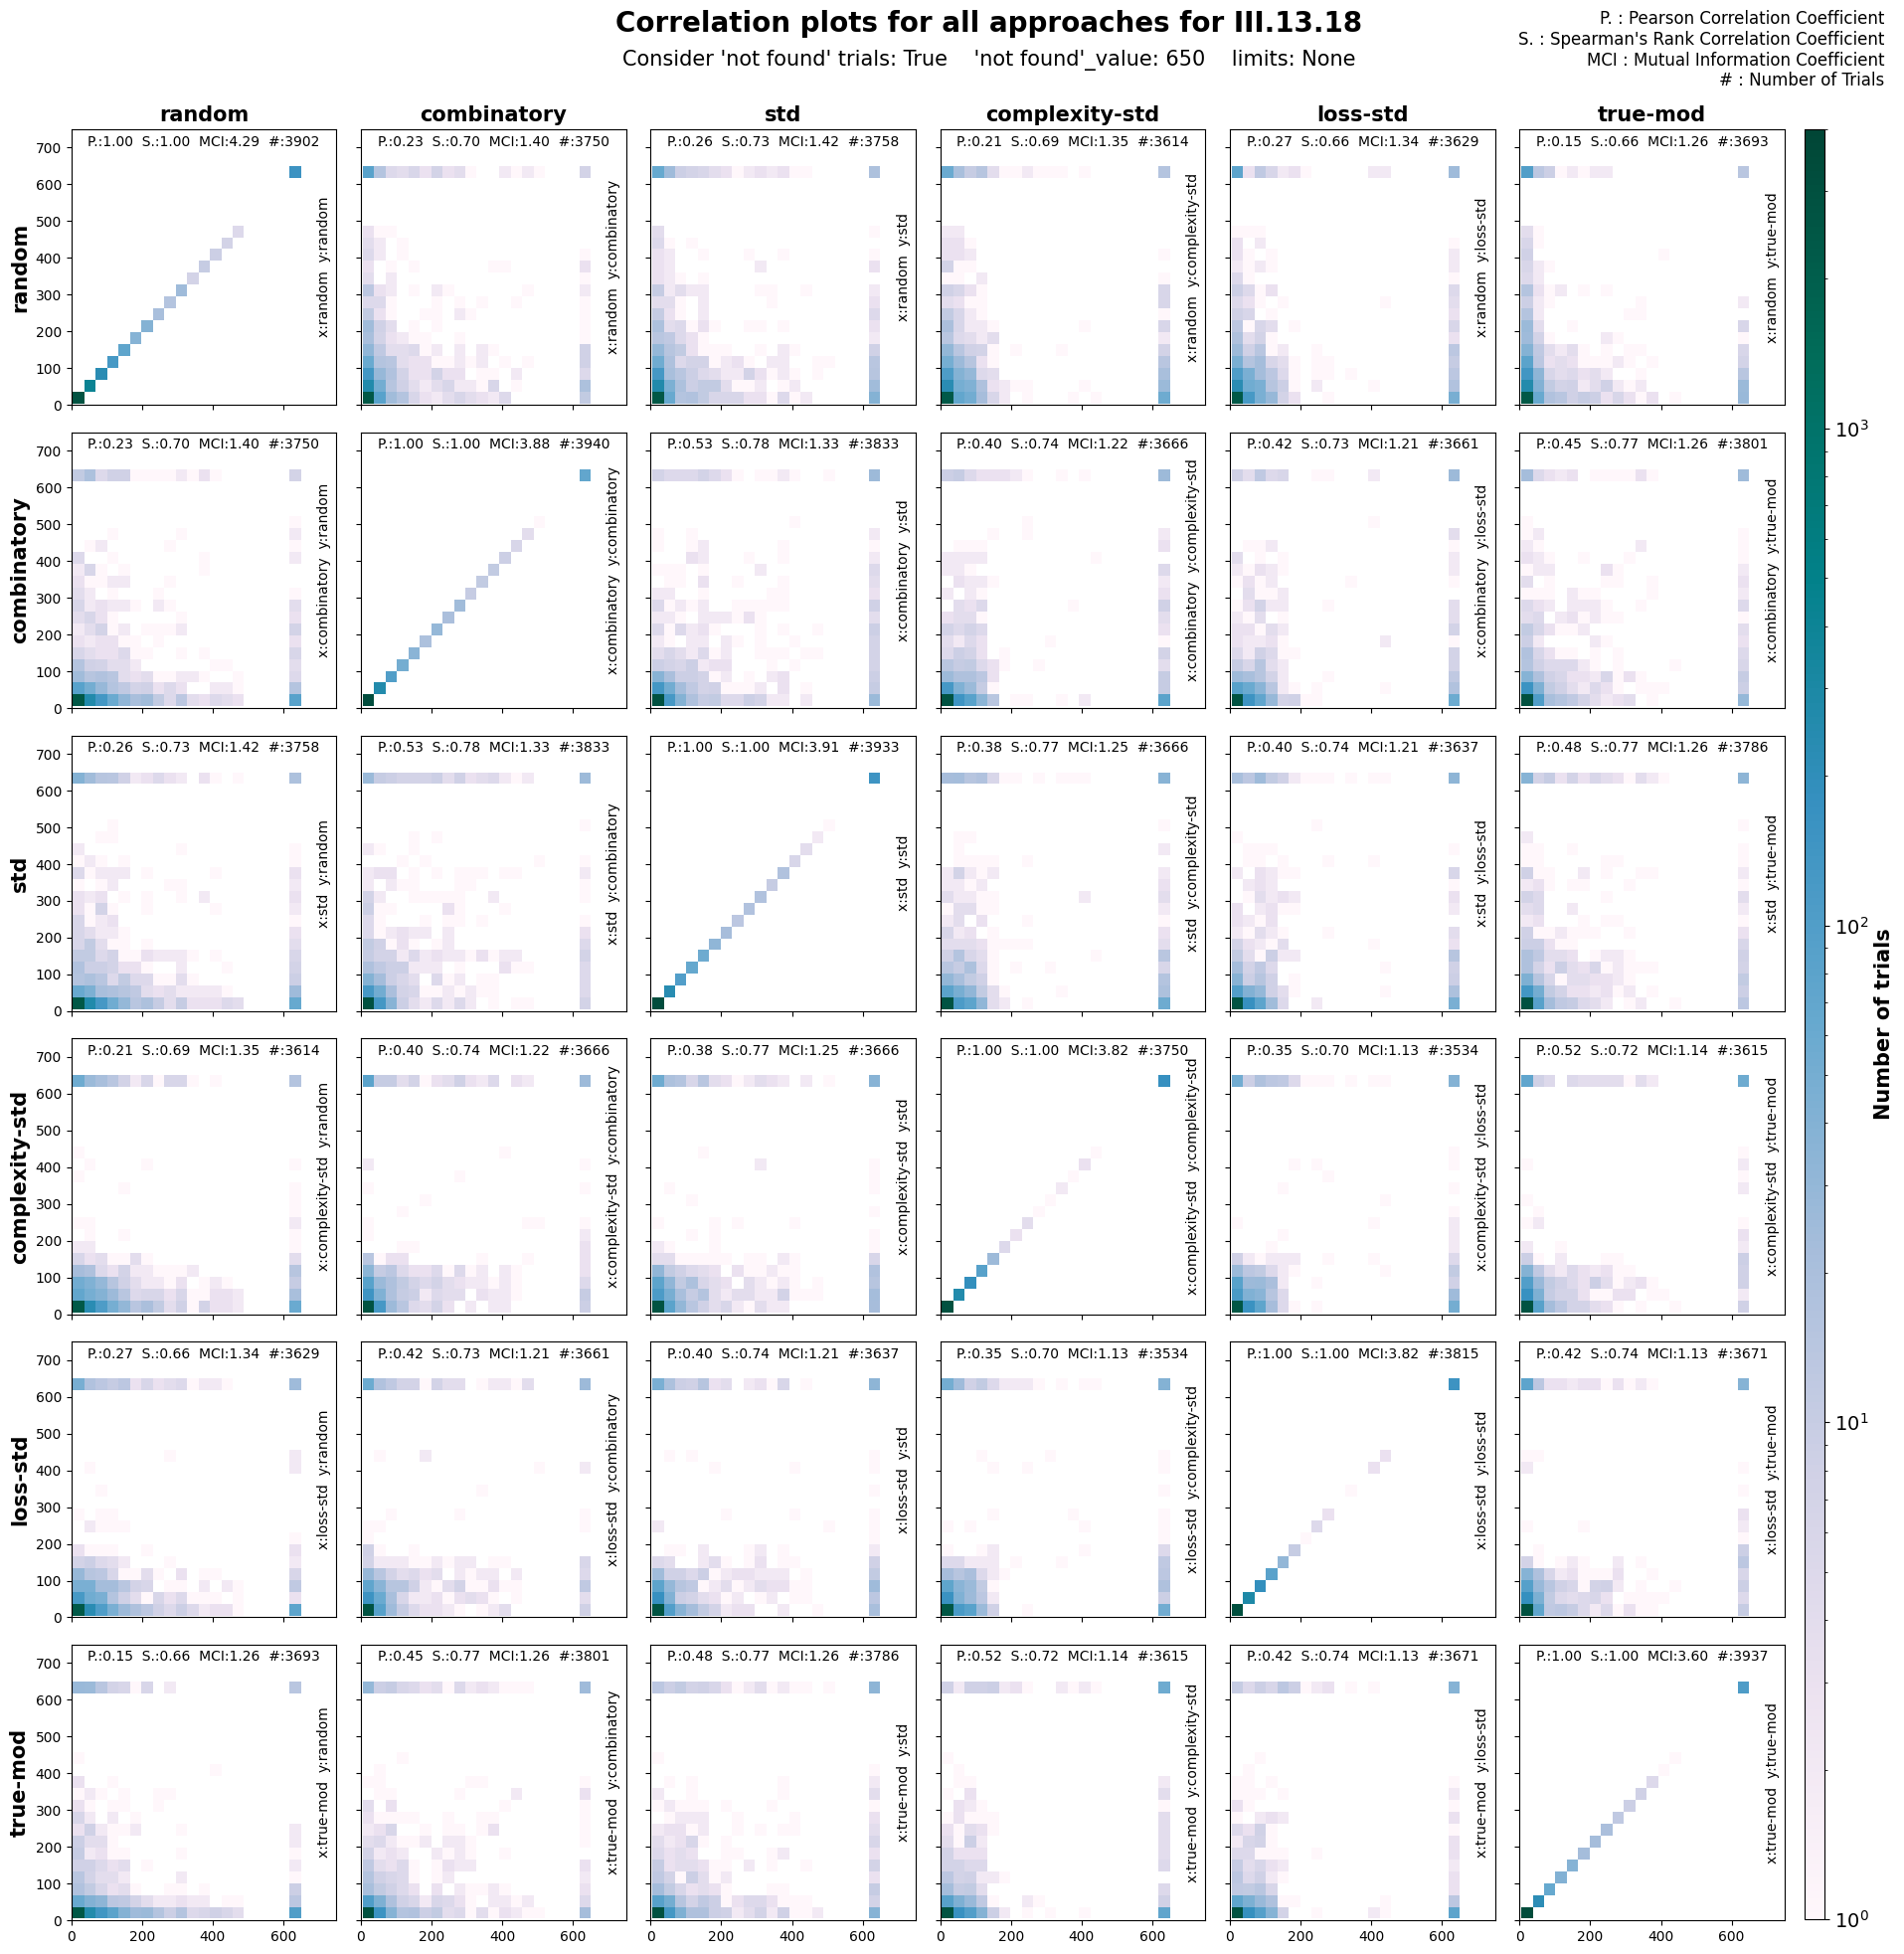

In [107]:
correlation_plot_comparison(trial_summary_dict, equation='III.13.18')